# Binding binary classifiers from pairwise datasets

We begin to explore the impact of negative examples on the training of binary binding classifiers by evaluating the classifiers' performances when using negative training examples from a single antigen, i.e. distinguish antigen_1 from antigen_2.

In [1]:
from pathlib import Path
from itertools import combinations
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def antigens_from_dir_name(dir_name: str) -> tuple:
    m = re.search(r"fit_pairwise_dataset_(.*)_(.*)_instruction", dir_name)
    if m:
        return m.groups()
    else:
        return None


BASE_PATH = Path("immuneML/pairwise_analysis_1_out")
pairwise_res = list(Path(BASE_PATH).glob("fit_pairwise_dataset_*_instruction"))

dfs = []
for res in pairwise_res:
    df_i = pd.read_csv(res / "binder_all_assessment_performances.csv")
    assert df_i.shape[0] == 1
    ag1, ag2 = antigens_from_dir_name(res.name)
    df_i["Ag1"] = ag1
    df_i["Ag2"] = ag2
    dfs.append(df_i)

df = pd.concat(dfs, axis=0)
assert df.shape[0] == 45
df.head(2)


,hp_setting,split,optimal,log_loss,f1_weighted,confusion_matrix,recall,f1_macro,auc,accuracy,balanced_accuracy,precision,f1_micro,Ag1,Ag2
0,kmerfreq_encoding_randomforest_default_model,1,False,3.041885,0.831382,[[17242 3761]\n [ 3318 17666]],0.841880,0.831383,0.095032,0.83140,0.831405,0.824474,0.83140,1H0D,3VRL
0,kmerfreq_encoding_randomforest_default_model,1,False,2.542403,0.742430,[[15568 5455]\n [ 5357 15597]],0.744345,0.742430,0.189646,0.74243,0.742434,0.740880,0.74243,1ADQ,3VRL


The dataset is balanced, hence `accuracy` is a good performance metric. Distribution of `accuracy` over the 45 pairwise datasets (10 choose 2 antigen pairs = 90/2) has a range of 69-88% with 2 local maxima around 77% and 83%, with an average of 79% and sd of 4.6%.

In [4]:
df["accuracy"].describe()

count    45.000000
mean      0.789380
std       0.045934
min       0.695675
25%       0.764536
50%       0.776219
75%       0.826985
max       0.877399
Name: accuracy, dtype: float64

<AxesSubplot:ylabel='Frequency'>

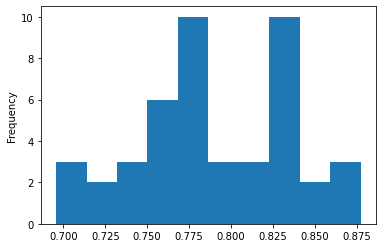

In [5]:
df["accuracy"].plot.hist()

In what follows, we check whether there are associations in terms of the ability of the binary classifier to distinguish an antigen from other. First, we generate the accuracy matrix, which describes the attained accuracy in distinguishing between a pair of antigens, e.g. row "1FBI" and column "1ADQ" describes the accuracy in distinguishing between 1FBI and 1ADQ.

In [6]:
antigens = sorted(set(df["Ag1"]).union(set(df["Ag2"])))
df_m = pd.DataFrame(np.zeros((10, 10)), columns = antigens, index = antigens)

for ag1, ag2 in combinations(antigens, 2):
    acc = df.loc[
        (df["Ag1"] == ag1) 
        & (df["Ag2"] == ag2)
        ]["accuracy"].values[0]
    df_m.loc[ag1, ag2] = acc
    df_m.loc[ag2, ag1] = acc

df_m

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
1ADQ,0.000000,0.759825,0.864820,0.826985,0.776219,0.828017,0.835716,0.755275,0.742430,0.827803
1FBI,0.759825,0.000000,0.826180,0.776105,0.766841,0.816285,0.764536,0.700324,0.801896,0.796136
1H0D,0.864820,0.826180,0.000000,0.877399,0.771776,0.841371,0.759753,0.769674,0.831400,0.767901
1NSN,0.826985,0.776105,0.877399,0.000000,0.803325,0.866798,0.776105,0.819399,0.854662,0.827636
1OB1,0.776219,0.766841,0.771776,0.803325,0.000000,0.774652,0.827366,0.732142,0.784588,0.727318
1WEJ,0.828017,0.816285,0.841371,0.866798,0.774652,0.000000,0.826013,0.700100,0.774359,0.818351
2YPV,0.835716,0.764536,0.759753,0.776105,0.827366,0.826013,0.000000,0.722884,0.733219,0.776092
3RAJ,0.755275,0.700324,0.769674,0.819399,0.732142,0.700100,0.722884,0.000000,0.695675,0.770442
3VRL,0.742430,0.801896,0.831400,0.854662,0.784588,0.774359,0.733219,0.695675,0.000000,0.826323
5E94,0.827803,0.796136,0.767901,0.827636,0.727318,0.818351,0.776092,0.770442,0.826323,0.000000


Next, we check the accuracy distribution for each antigen. We observe below that:

1. The maximal accuracy varies among the antigens, e.g. max for `1H0D` 87.7% vs max for `3RAJ` 82% (delta ~5%).
2. The minimal accuracy varies among the antigens, e.g. min for `1NSN` 77.6% vs min for `3VRL` of 69.5% (delta ~8%). 

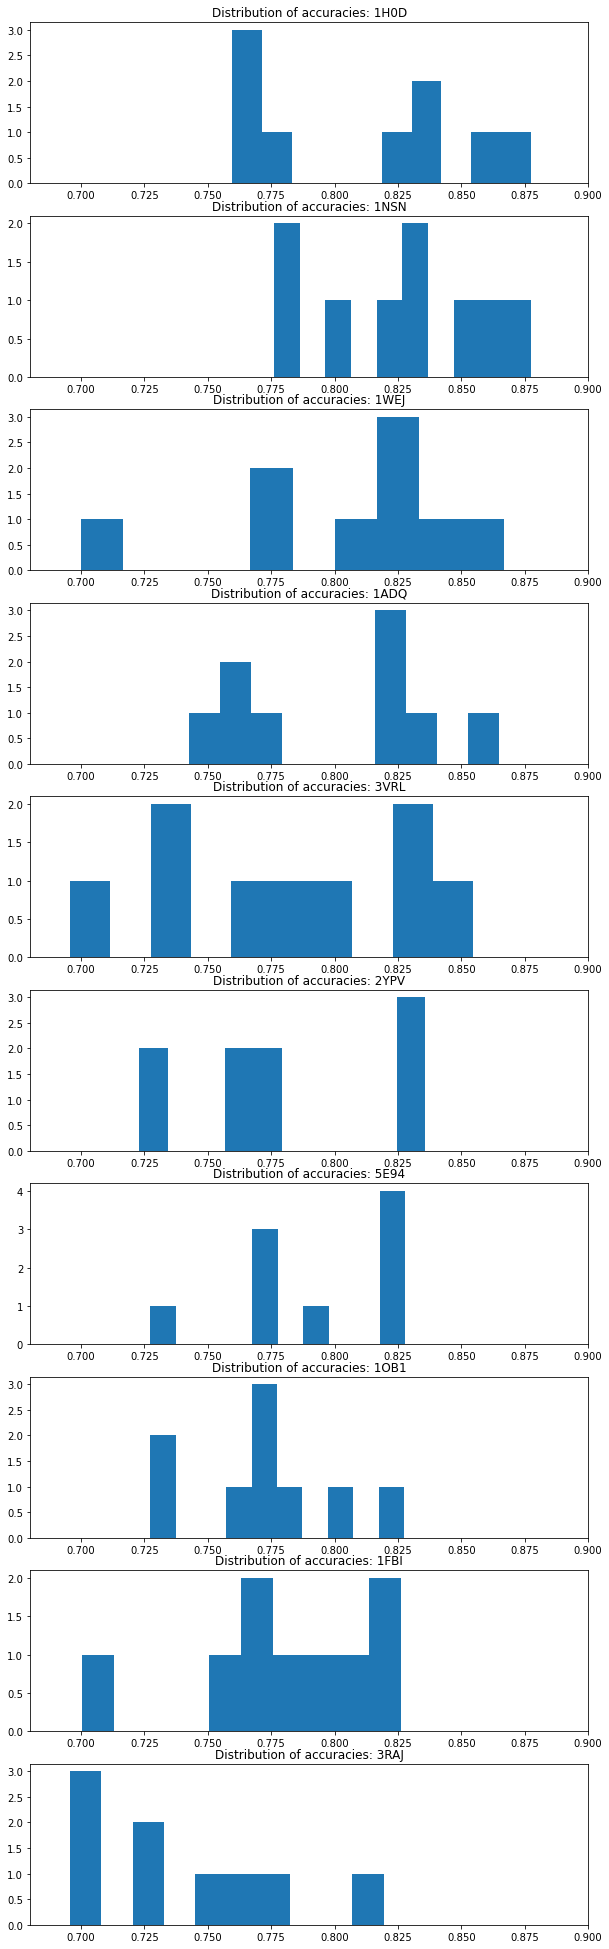

In [7]:
fig, axs = plt.subplots(
    nrows=10, 
    sharex=False,
    figsize=(10, 35)
)

for i, ag in enumerate(sorted(antigens, key=lambda ag: -df_m.apply(max).to_dict().get(ag))):
    acc_s = df_m[ag]
    acc_s = acc_s[acc_s != 0.0]
    axs[i].hist(acc_s)
    axs[i].set_xlim((0.68, 0.9))
    axs[i].set_title(f"Distribution of accuracies: {ag}")

# Follow-up

Similar basic analysis on `1_vs_all` datasets, i.e. datasets in which, for each antigen, we include all the 9 other antigens in the negative dataset. The objective is to check if antigens for which the binary classifier performs well in the pairwise datasets attain higher performance in `1_vs_all` datasets.